# Next Step: Tune Random Forest Model

Business problem: Customers get Peloton bike delivered and ask, what class should I take first?

Difficulty will be basis of how they choose - build model to predict difficulty based on class daya including roll up stats of playlist.

False Positive - a class is labeled easy, but it isn't
False Negative - a class is not labeled easy, but it is

**Both are equally important to account for - use F1 Score**

Note: A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, **micro-average is preferable if you suspect there might be class imbalance (i.e you may have many more examples of one class than of other classes).**
Source: https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin

In [1]:
# Basics 
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

# Importing dfs with heavy processing
import pickle

# Imports Modeling
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, plot_confusion_matrix

# Feat Imp
from yellowbrick.model_selection import FeatureImportances

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
# Just in case other pickle files available
# # Opening pickle files
# # Use classId where you can as key for merging
# base_clean_df = pd.read_pickle("../../data/pickled_dfs/base_clean_df.pkl")
# artist_df = pd.read_pickle("../../data/pickled_dfs/artist_df.pkl")
# artist_id_class_count = pd.read_pickle("../../data/pickled_dfs/larger_spot_artist_id_class_count.pkl")  # has artist features
# songs_df = pd.read_pickle("../../data/pickled_dfs/songs_df.pkl")
# song_class_count_df = pd.read_pickle("../../data/pickled_dfs/song_class_count_df.pkl")
# song_class_count_df.rename(columns={'Artist':'Song'}, inplace=True) # Quick clean rename column
# class_type_reorg_df = pd.read_pickle("../../data/pickled_dfs/class_type_reorg_df.pkl")
# new_class_types_with_artists = pd.read_pickle("../../data/pickled_dfs/new_class_types_with_artists.pkl")
# master_song_df = pd.read_pickle("../../data/pickled_dfs/master_song_df.pkl") # has song features
# # artist_id_class_count has 186 rows with 0LyfQWJT6nXafLPZqxe9Of - it means Various Artists
# # and 40 errors

In [2]:
df = pd.read_pickle("../../data/pickled_dfs/master_first_classes_with_stats.pkl")
df.head()

,classId,className,classDescription,classDifficulty,classDuration,classType,classLength,classLocation,classOriginalAirdate,classRating,classRatingCount,instructorName,instructorBio,classEquipment,classSongs,classArtists,classUrl,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,popularity_artist,duration_mins,classCategory
0,9680a817bf2149d2b91990c87166a400,20 min Pop Ride,We dare you not to dance as you ride to all th...,7.4000,20,Cycling,24,uk,2021-09-03 07:52:00,1.0000,82,Sam Yo,Sam is a pro at many things but shines when it...,Bike,"Señorita,Marry You,Irreplaceable,What Do You M...","Justin Timberlake,Bruno Mars,Beyoncé,Justin Bi...",https://members.onepeloton.com/classes/bootcam...,65.0,0.0,0.6675,0.6635,7.5,-5.1020,1.0,0.05940,0.243500,0.000711,0.1355,0.6470,116.5345,4.0,18846591.5,86.0,3.611225,Music
1,932f15ed407f46049988ba4c46e3ee3b,20 min HIIT Ride,"Powerful and efficient, this high-intensity in...",7.7203,20,Cycling,24,uk,2021-09-03 07:25:00,0.9889,90,Sam Yo,Sam is a pro at many things but shines when it...,Bike,Just Like Fire (From the Original Motion Pictu...,"P!nk,P!nk,Justin Bieber,Britney Spears,London ...",https://members.onepeloton.com/classes/bootcam...,33.5,0.0,0.6625,0.7610,4.5,-6.5125,1.0,0.05405,0.002405,0.001189,0.0946,0.4025,129.5015,4.0,9809178.0,85.0,5.703883,Intervals
2,9319eb174dee4cb081f6491cc81e7c7e,30 min Advanced Beginner Ride,Still warming up but ready for more? Build on ...,8.0000,30,Cycling,33,uk,2021-09-03 06:00:00,1.0000,1,Hannah Frankson,Hannah’s electric spirit empowers others to sh...,Bike,"Angel,As Long As You Love Me (feat. Big Sean),...","Shaggy,Rayvon,Justin Bieber,Big Sean,Blonde,Cr...",https://members.onepeloton.com/classes/bootcam...,64.0,0.0,0.6220,0.8070,5.0,-5.1530,0.0,0.04180,0.100000,0.000007,0.2720,0.6500,140.0140,4.0,633128.5,67.5,3.729600,Beginner
3,8a8c181b523b430487f6a23bb0436178,30 min Pop Ride,We dare you not to dance as you ride to all th...,7.6487,30,Cycling,34,psny-studio-1,2021-09-03 00:21:00,0.9956,2964,Cody Rigsby,"A former professional dancer, Cody brings ener...",Bike,"I Love Rock 'N' Roll,Blow Me (One Last Kiss) (...","Britney Spears,P!nk,P!nk,Ashlee Simpson,Kelly ...",https://members.onepeloton.com/classes/bootcam...,60.0,0.0,0.5260,0.7680,7.0,-4.7150,1.0,0.04140,0.001400,0.000020,0.1440,0.4240,139.1150,4.0,8877968.0,84.0,3.624000,Music
4,8903dfb7bae742a9bd00bf3afd718afa,20 min 80s Ride,Take a ride through the classic tracks of the ...,7.1325,20,Cycling,23,psny-studio-1,2021-08-03 22:00:00,0.9895,857,Christine D'Ercole,Christine D’Ercole is a decorated track cyclis...,Bike,"The Tide Is High,Take on Me (2016 Remaster),An...","Blondie,a-ha,a-ha,Juice Newton,Tommy Tutone,Bo...",https://members.onepeloton.com/classes/bootcam...,45.0,0.0,0.5880,0.6830,7.0,-11.9670,1.0,0.04000,0.024300,0.001260,0.0861,0.8110,137.6330,4.0,641882.5,63.0,3.800000,Music


In [4]:
df['classDifficulty'].describe()

count    6983.000000
mean        7.858991
std         0.778619
min         4.272800
25%         7.554450
50%         8.047400
75%         8.378250
max         9.653600
Name: classDifficulty, dtype: float64

In [5]:
def label_class_diff_cat(classDifficulty):
    if classDifficulty < 7.55:
        return 'Beginner'
    if classDifficulty >= 7.55 and classDifficulty < 8.37:
        return 'Intermediate'
    if classDifficulty >= 8.37:
        return 'Advanced'

In [6]:
# Create classDifficulty_cat for categories of Class Difficulty for classification target
df['classDifficulty_cat'] = df['classDifficulty'].apply(label_class_diff_cat)

In [7]:
#### Create Other Categories Instructor and Class
other_instructors = ['Irène Scholz', 'Erik Jäger', 'Christian Vande Velde', 'Cliff Dwenger',
                     'Alex & Tunde', 'Mayla Wedekind', 'Ally & Emma', 'Cycling Instructors 2019']

df['instructorName'] = df['instructorName'].replace(other_instructors, 'Other')


# Recategorize low count classes
# Create Other category for those <50 
# Put Groove Cody classes into Theme - not a music genre or year, but a programmatic type class like XOXO
df['classCategory'] = df['classCategory'].replace({'Heart Rate Zone' : 'Other',
                                                   'Live DJ' : 'Other',
                                                   'Pro Cyclist' : 'Other',
                                                   'Groove': 'Theme'})

## Modeling

In [8]:
def eval_model(estimator, X_train, X_test, y_train, y_test, target_names, average):
    '''
    Evaluation function to show accuracy, f1 score, mean 3-fold cross-validation 
    for both the train and test set, then shows confusion matrix for the test set
    '''   
    # grab predictions
    train_preds = estimator.predict(X_train)
    test_preds = estimator.predict(X_test)
    
    # print report
    print(classification_report(y_test, test_preds, target_names=target_names))
    
    # print scores
    print("Train Scores")
    print("------------")
    print(f"Accuracy: {accuracy_score(y_train, train_preds)}")
    print(f"F1 Score: {f1_score(y_train, train_preds, average=average)}")
    print("----" * 5)
    print("Test Scores")
    print("-----------")
    print(f"Accuracy: {accuracy_score(y_test, test_preds)}")
    print(f"F1 Score: {f1_score(y_test, test_preds, average=average)}")
    print(f"F1 Score Mean Cross Val 3-Fold: {np.mean(cross_val_score(estimator,  X_train, y_train, cv=3, scoring=(f'f1_{average}')))}")
    
#     # append to df
#     new_row = calc_scores(data_version, estimator, X_train, X_test, y_train, y_test, target_names, average)
#     new_row_df = pd.DataFrame(new_row)
#     frames = [model_results,new_row_df]
#     model_results = pd.concat(frames)
#     model_results.head()
    
    # plot test confusion matrix
    plot_confusion_matrix(estimator, X_test, y_test, values_format='')
    plt.show()

### Data (drop 'Other' categories and time signature- not impactful)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6983 entries, 0 to 6982
Data columns (total 36 columns):
classId                 6983 non-null object
className               6983 non-null object
classDescription        6983 non-null object
classDifficulty         6983 non-null float64
classDuration           6983 non-null int64
classType               6983 non-null object
classLength             6983 non-null int64
classLocation           6983 non-null object
classOriginalAirdate    6983 non-null object
classRating             6983 non-null float64
classRatingCount        6983 non-null int64
instructorName          6983 non-null object
instructorBio           6983 non-null object
classEquipment          6983 non-null object
classSongs              6983 non-null object
classArtists            6983 non-null object
classUrl                6983 non-null object
popularity_song         6983 non-null float64
explicit                6983 non-null float64
danceability            6983 non-null

In [10]:
# Define X and y 

# Still using classCategory and dropping className
# Additionally dropping classLocation
X = df.drop(columns=['classId', 'classDifficulty', 'classDifficulty_cat', 'classOriginalAirdate', 
                     'classType', 'classLength', 'instructorBio', 'classEquipment', 'classUrl', 
                     'classRating', 'classRatingCount', 'classDescription', 'classSongs', 'classArtists',
                    'className', 'classLocation', 'time_signature'])

#y is the target created previously
y = df['classDifficulty_cat']

### Manual

In [11]:
# Replace className with classCategory in ohe_cols
num_cols = ['classDuration', 'popularity_song', 'explicit', 'danceability', 'energy', 'key', 
            'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
            'valence', 'tempo', 'followers', 'popularity_artist', 'duration_mins']

ohe_cols = ['classCategory', 'instructorName']

#### Numeric Treatment - Scale

In [12]:
# Copy df for manipulation
scaled_features = df.copy()

In [13]:
# Scale num_col features
features = scaled_features[num_cols]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

# Put into DF for concatenation
scaled_features[num_cols] = features
scaled = scaled_features[num_cols]

# Check work
scaled.head()

,classDuration,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,followers,popularity_artist,duration_mins
0,-0.925958,0.889340,-0.26515,0.343782,-0.733255,0.999161,0.884929,0.690826,-0.164187,1.428143,-0.188866,-0.208301,0.540099,-0.292372,4.706645,1.659780,-0.471883
1,-0.925958,-1.671140,-0.26515,0.283662,0.263357,-0.427414,0.094531,0.690826,-0.295639,-0.832514,-0.181636,-0.913120,-1.163569,0.766823,2.040890,1.531502,3.939918
2,-0.053947,0.808055,-0.26515,-0.203303,0.733554,-0.189652,0.856351,-1.671005,-0.596627,0.082597,-0.199516,2.143967,0.561003,1.625525,-0.665758,-0.713377,-0.222322
3,-0.053947,0.482915,-0.26515,-1.357593,0.334909,0.761399,1.101792,0.690826,-0.606455,-0.841938,-0.199307,-0.061823,-1.013758,1.552091,1.766212,1.403223,-0.444950
4,-0.925958,-0.736362,-0.26515,-0.612114,-0.533932,0.761399,-2.961995,0.690826,-0.640854,-0.627213,-0.180555,-1.059598,1.682846,1.431036,-0.663176,-1.290632,-0.073902


#### Categorical Treatment (OHE)

In [14]:
# Copy df for manipulation
ohe_features = df.copy()

In [15]:
# Filter down to just ohe_cols
ohe_features = ohe_features[ohe_cols]

# OHE/Get Dummies
ohe_features = pd.get_dummies(ohe_features)

# Preview, check work
ohe_features.head()

,classCategory_Beginner,classCategory_Climb,classCategory_Intervals,classCategory_Low Impact,classCategory_Music,classCategory_Other,classCategory_Power Zone,classCategory_Theme,instructorName_Alex Toussaint,instructorName_Ally Love,instructorName_Ben Alldis,instructorName_Christine D'Ercole,instructorName_Cody Rigsby,instructorName_Denis Morton,instructorName_Emma Lovewell,instructorName_Hannah Corbin,instructorName_Hannah Frankson,instructorName_Jenn Sherman,instructorName_Jess King,instructorName_Kendall Toole,instructorName_Leanne Hainsby,instructorName_Matt Wilpers,instructorName_Olivia Amato,instructorName_Other,instructorName_Robin Arzón,instructorName_Sam Yo,instructorName_Tunde Oyeneyin
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
ohe_features = pd.get_dummies(ohe_features)

In [17]:
# Drop Other categories and reset index
ohe_features = ohe_features.drop(columns=['classCategory_Other', 'instructorName_Other']).reset_index(drop=True)

#### Combine

In [18]:
# Combine scaled numerical, OHE categoricals, and target into one df
preprocessed = pd.concat([scaled, ohe_features, y], axis=1)

In [19]:
# Review available columns, check work
preprocessed.columns

Index(['classDuration', 'popularity_song', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'followers', 'popularity_artist', 'duration_mins', 'classCategory_Beginner', 'classCategory_Climb', 'classCategory_Intervals', 'classCategory_Low Impact', 'classCategory_Music', 'classCategory_Power Zone', 'classCategory_Theme', 'instructorName_Alex Toussaint', 'instructorName_Ally Love', 'instructorName_Ben Alldis', 'instructorName_Christine D'Ercole', 'instructorName_Cody Rigsby', 'instructorName_Denis Morton', 'instructorName_Emma Lovewell', 'instructorName_Hannah Corbin', 'instructorName_Hannah Frankson', 'instructorName_Jenn Sherman', 'instructorName_Jess King', 'instructorName_Kendall Toole', 'instructorName_Leanne Hainsby', 'instructorName_Matt Wilpers', 'instructorName_Olivia Amato', 'instructorName_Robin Arzón', 'instructorName_Sam Yo', 'instructorName_Tunde Oyeneyin',
       'classDifficu

In [20]:
preprocessed.head()

,classDuration,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,followers,popularity_artist,duration_mins,classCategory_Beginner,classCategory_Climb,classCategory_Intervals,classCategory_Low Impact,classCategory_Music,classCategory_Power Zone,classCategory_Theme,instructorName_Alex Toussaint,instructorName_Ally Love,instructorName_Ben Alldis,instructorName_Christine D'Ercole,instructorName_Cody Rigsby,instructorName_Denis Morton,instructorName_Emma Lovewell,instructorName_Hannah Corbin,instructorName_Hannah Frankson,instructorName_Jenn Sherman,instructorName_Jess King,instructorName_Kendall Toole,instructorName_Leanne Hainsby,instructorName_Matt Wilpers,instructorName_Olivia Amato,instructorName_Robin Arzón,instructorName_Sam Yo,instructorName_Tunde Oyeneyin,classDifficulty_cat
0,-0.925958,0.889340,-0.26515,0.343782,-0.733255,0.999161,0.884929,0.690826,-0.164187,1.428143,-0.188866,-0.208301,0.540099,-0.292372,4.706645,1.659780,-0.471883,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,Beginner
1,-0.925958,-1.671140,-0.26515,0.283662,0.263357,-0.427414,0.094531,0.690826,-0.295639,-0.832514,-0.181636,-0.913120,-1.163569,0.766823,2.040890,1.531502,3.939918,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,Intermediate
2,-0.053947,0.808055,-0.26515,-0.203303,0.733554,-0.189652,0.856351,-1.671005,-0.596627,0.082597,-0.199516,2.143967,0.561003,1.625525,-0.665758,-0.713377,-0.222322,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,Intermediate
3,-0.053947,0.482915,-0.26515,-1.357593,0.334909,0.761399,1.101792,0.690826,-0.606455,-0.841938,-0.199307,-0.061823,-1.013758,1.552091,1.766212,1.403223,-0.444950,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Intermediate
4,-0.925958,-0.736362,-0.26515,-0.612114,-0.533932,0.761399,-2.961995,0.690826,-0.640854,-0.627213,-0.180555,-1.059598,1.682846,1.431036,-0.663176,-1.290632,-0.073902,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Beginner


#### RF with Balanced Class Weight  (rf7 in notebook 91_)

Class weight = 'balanced' to account for 25-50-25 split of Target

In [21]:
# X and y split of preprocessed 
X = preprocessed.drop(columns=['classDifficulty_cat'], axis=1)
y = preprocessed['classDifficulty_cat']

In [22]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [23]:
# Instantiate
rf = RandomForestClassifier(class_weight='balanced')

# Fit
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

              precision    recall  f1-score   support

    Beginner       0.80      0.57      0.67       459
Intermediate       0.82      0.69      0.75       426
    Advanced       0.70      0.86      0.77       861

    accuracy                           0.74      1746
   macro avg       0.77      0.71      0.73      1746
weighted avg       0.76      0.74      0.74      1746

Train Scores
------------
Accuracy: 0.9998090509833875
F1 Score: 0.9998090509833875
--------------------
Test Scores
-----------
Accuracy: 0.7434135166093929
F1 Score: 0.7434135166093929
F1 Score Mean Cross Val 3-Fold: 0.7359160684922066


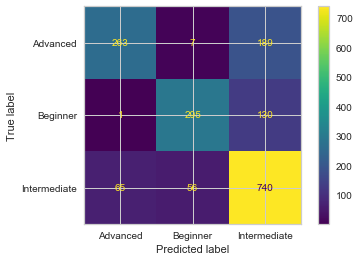

In [24]:
# Try micro 
eval_model(rf, X_train, X_test, y_train, y_test, ['Beginner', 'Intermediate', 'Advanced'], average='micro')

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


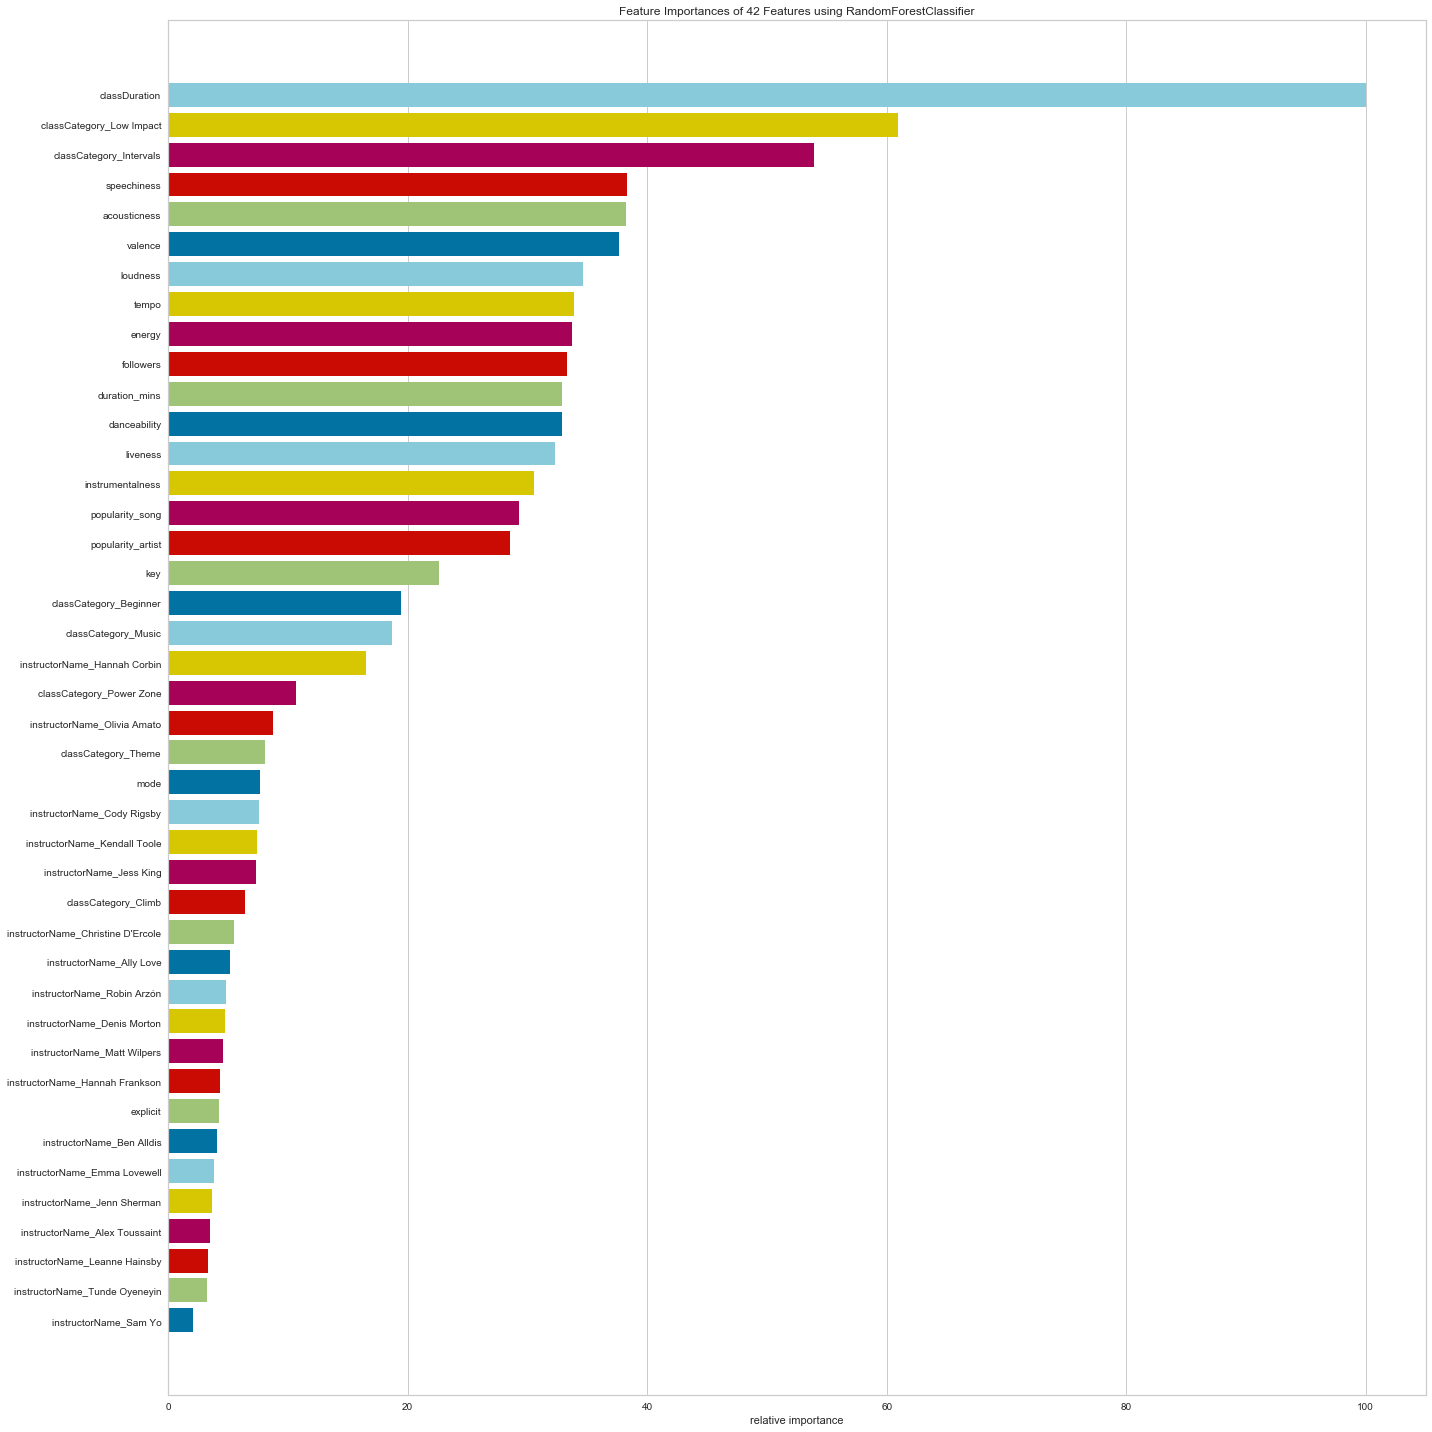

In [25]:
plt.figure(figsize=(20,20))
viz = FeatureImportances(rf)
viz.fit(X, y)
viz.show()

### Tuning RF

As a start, Randomized Search with a grid of hyperparameters that will be randomly sampled and then cross validated for each combination. Will use this to pare down the ranges in the grid values and then utilize Grid Search.

In [41]:
from sklearn.model_selection import RandomizedSearchCV

In [42]:
# Source: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [43]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfc = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, 
                                cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring='f1_micro')
# Fit the random search model
rfc_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.8min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [46]:
rfc_random.best_params_

{'n_estimators': 2000,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 60,
 'bootstrap': False}

In [47]:
rfc_random.best_score_

0.7531031223229846